# Kalman Example

研究目的：
- 使用ETF的价格进行模拟
- 使用Kalman方程计算beta、alpha

## 步骤1

提取有效的ETF数据信息

In [1]:
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')

In [2]:
# 候选ETF
# 510050：上证50ETF
# 159919：沪深300ETF
# 510500：中证500
# 512100：中证1000
# 159915：易方达创业板指数

# ETF是一揽子股票，没有相应组成部分，只能从字面上理解相应的组成，通过指数来进行模拟

candidate_ETF = [
    "510050.XSHG",
    "159919.XSHE",
    "510500.XSHG",
    "512100.XSHG",
    "159915.XSHE"
]


# 确定整体时间长度，默认设置为过去300天
ncount = 300

# 确定end_date
end_date='2024-04-15'

In [3]:
# 生成价格pandas数组
price_pd = pd.DataFrame()


for ETF_i in candidate_ETF:
    
    # 初始变量命名
    ETF_i_name = ""
    ETF_i_name = str(ETF_i[:6]) + "_ETF"
    
    # 显示过程
    print(ETF_i_name)

    # 提取价格数据
    price_ETF_temp = pd.DataFrame()
    price_ETF_temp = get_price(ETF_i, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']
    price_ETF_temp.name = ETF_i_name
    
    # 数据合并
    price_pd = pd.concat([price_pd,price_ETF_temp], axis = 1)


510050_ETF
159919_ETF
510500_ETF
512100_ETF
159915_ETF


In [4]:
price_pd.head()

,510050_ETF,159919_ETF,510500_ETF,512100_ETF,159915_ETF
2023-01-16,2.802,4.208,6.143,2.636,2.462
2023-01-17,2.793,4.210,6.151,2.633,2.470
2023-01-18,2.774,4.199,6.175,2.641,2.468
2023-01-19,2.784,4.232,6.232,2.672,2.496
2023-01-20,2.803,4.253,6.277,2.697,2.507


## 步骤2

对数据进行分析，直接使用价格数据进行模拟建模



In [5]:
# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [6]:
# 确定X、Y变量

# 初始设置，以沪深300为X变量基准，以上证50为Y变量
X_benchmark =  price_pd['159919_ETF']
Y_pred = price_pd['510050_ETF']

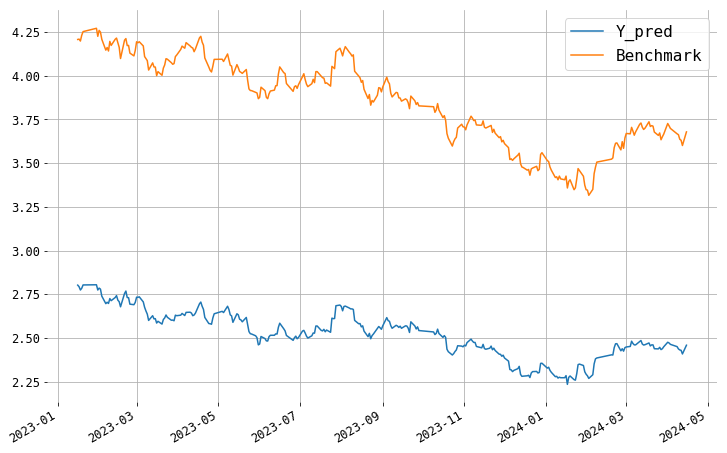

In [7]:
# 进行画图
pd.concat([Y_pred, X_benchmark], axis=1).plot()
plt.legend(['Y_pred', 'Benchmark']);

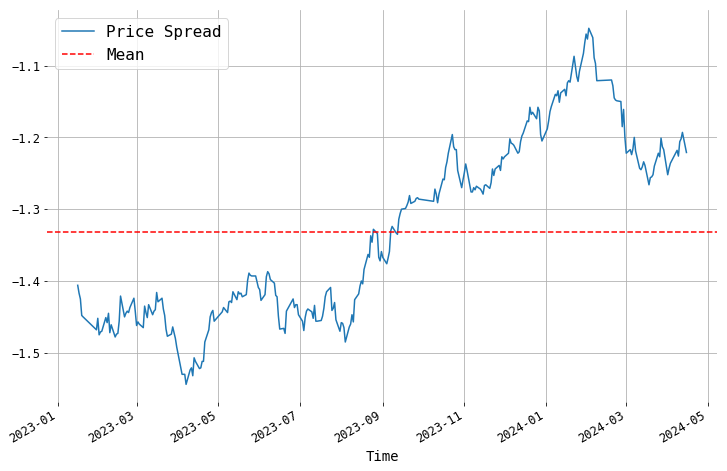

In [8]:
# 画出价格变化趋势
(Y_pred -  X_benchmark).plot() # Plot the spread
plt.axhline((Y_pred -  X_benchmark).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);

**确定了两个基本价格：**

“159919_ETF”为benchmark

“510050_ETF”为预测值Y_pred

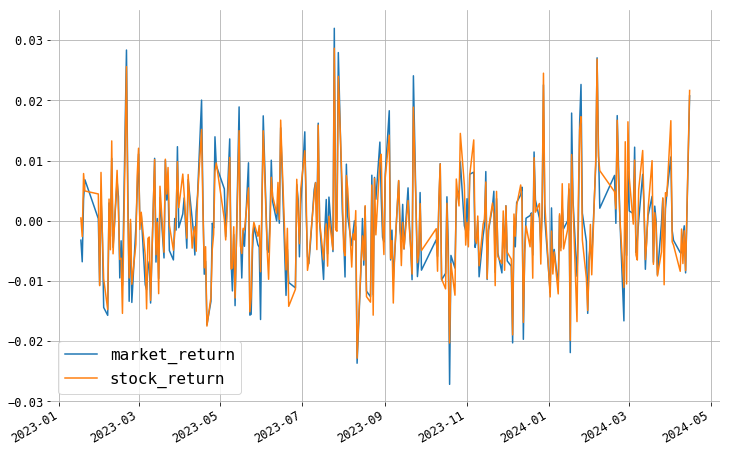

In [9]:
# transfer to yield
market_return = Y_pred.pct_change()
stock_return = X_benchmark.pct_change()

# 进行画图
pd.concat([market_return, stock_return], axis=1).plot()
plt.legend(['market_return', 'stock_return']);

In [10]:
market_return = market_return.fillna(0)
stock_return = stock_return.fillna(0)

## Step3：使用Kalman方程

Kalman方程基本模型：
1. Model assumption：
    * State Variable: $\beta$
    * State Equation: $\beta_{t+1} = \beta_t + w_t $
    * Observation Model: $r_{\text{stock},t} = \beta_t \cdot r_{\text{market},t} + \epsilon_t$ (只看得到收益率r，但是看不到beta具体的值
    
2. Implementation detail
    * 需要转化为收益率
    * 使用基准数据和预测数据进行
    * 使用Kalman方程进行预测
    
3. Observe matrix
    * 对应的观察元素是$r_{\text{stock}, t}$,公式为：$r_{\text{stock}, t} = \alpha + \beta \times r_{\text{market}, t} + \epsilon_t$
    * 对应的观察矩阵为：$H_t = \begin{bmatrix} 1 & r_{\text{market}, t} \end{bmatrix}$
    * 是观察矩阵的一部分： $r_{\text{market}, t}$
 
 
* 代码案例

```

# 创建一个 Kalman 滤波器实例
kf = KalmanFilter(
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.eye(n_dim_state),
    transition_matrices=np.eye(n_dim_state),
    observation_matrices=np.ones((n_dim_obs, n_dim_state)),
    transition_covariance=np.eye(n_dim_state),
    observation_covariance=np.eye(n_dim_obs)
)

# 执行滤波
state_means, state_covariances = kf.filter(observations)


```

In [15]:
from pykalman import KalmanFilter


initial_state_mean=[0.0, 1.0]               # 初始状态估计
initial_state_covariance=0.01 * np.eye(2)   # 初始的状态误差


# 观测值是股票的收益率
observations = stock_return

# 市场收益率market_return是观测矩阵的一部分
# 设置观测矩阵，每个时间点更新
observation_matrices = np.array([[1, market_i] for market_i in market_return])
observation_covariance=0.01,  # 观测噪声协方差        



In [16]:
# Kalman Filter 设置
kf = KalmanFilter(n_dim_obs=1,     # 一维观测数据
                  n_dim_state=2,   # 两个状态变量：alpha和beta
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  transition_matrices=np.eye(2),  # 状态转移矩阵
                  transition_covariance=0.01 * np.eye(2)    # 状态转移协方差
                 )  # 初始状态协方差


# 临时暂存，初始值是多少无所谓，和初始值一样
current_state_mean = initial_state_mean
current_state_covariance = initial_state_covariance


In [17]:
for t in range(len(observations)):

    # 每个时间步的观测矩阵可能不同
    observation_matrix_t = observation_matrices[t,:]
    
    # 开始进行update，每一个时间步的观测矩阵不同
    # 注意其中的observation_matrices[t,:]是一个元素，要在外层增加一个[]
    current_state_mean, current_state_covariance = kf.filter_update(
                    current_state_mean, 
                    current_state_covariance, 
                    observation= observations[t],
                    observation_matrix = np.array([observation_matrices[t,:]])
    )
    
    
    # 打印记录
    print("第%d次循环，总共%d次，当前的参数1为：%f，当前的参数2为%f"%(t,len(observations),float(current_state_mean[0]),float(current_state_mean[1])))


第0次循环，总共300次，当前的参数1为：0.000000，当前的参数2为1.000000
第1次循环，总共300次，当前的参数1为：0.000106，当前的参数2为1.000000
第2次循环，总共300次，当前的参数1为：0.000258，当前的参数2为0.999999
第3次循环，总共300次，当前的参数1为：0.000439，当前的参数2为0.999999
第4次循环，总共300次，当前的参数1为：0.000319，当前的参数2为0.999998
第5次循环，总共300次，当前的参数1为：0.000541，当前的参数2为0.999998
第6次循环，总共300次，当前的参数1为：0.000502，当前的参数2为0.999999
第7次循环，总共300次，当前的参数1为：0.000749，当前的参数2为1.000000
第8次循环，总共300次，当前的参数1为：0.000680，当前的参数2为1.000000
第9次循环，总共300次，当前的参数1为：0.000993，当前的参数2为0.999995
第10次循环，总共300次，当前的参数1为：0.000991，当前的参数2为0.999995
第11次循环，总共300次，当前的参数1为：0.000963，当前的参数2为0.999994
第12次循环，总共300次，当前的参数1为：0.000693，当前的参数2为0.999995
第13次循环，总共300次，当前的参数1为：0.000884，当前的参数2为0.999998
第14次循环，总共300次，当前的参数1为：0.000711，当前的参数2为1.000000
第15次循环，总共300次，当前的参数1为：0.000804，当前的参数2为1.000001
第16次循环，总共300次，当前的参数1为：0.000518，当前的参数2为0.999999
第17次循环，总共300次，当前的参数1为：0.000751，当前的参数2为0.999994
第18次循环，总共300次，当前的参数1为：0.000417，当前的参数2为0.999996
第19次循环，总共300次，当前的参数1为：-0.000053，当前的参数2为1.000006
第20次循环，总共300次，当前的参数1为：-0.000305，当前的参数2为0.999989
第21次循环，总共300次，当前的参数1为

第181次循环，总共300次，当前的参数1为：-0.000053，当前的参数2为0.998253
第182次循环，总共300次，当前的参数1为：-0.000176，当前的参数2为0.998257
第183次循环，总共300次，当前的参数1为：-0.000589，当前的参数2为0.998285
第184次循环，总共300次，当前的参数1为：-0.000188，当前的参数2为0.998339
第185次循环，总共300次，当前的参数1为：-0.000223，当前的参数2为0.998334
第186次循环，总共300次，当前的参数1为：-0.000320，当前的参数2为0.998323
第187次循环，总共300次，当前的参数1为：0.000155，当前的参数2为0.998424
第188次循环，总共300次，当前的参数1为：0.000784，当前的参数2为0.998426
第189次循环，总共300次，当前的参数1为：0.000481，当前的参数2为0.998430
第190次循环，总共300次，当前的参数1为：0.000060，当前的参数2为0.998394
第191次循环，总共300次，当前的参数1为：-0.000202，当前的参数2为0.998399
第192次循环，总共300次，当前的参数1为：-0.000196，当前的参数2为0.998400
第193次循环，总共300次，当前的参数1为：0.000333，当前的参数2为0.998477
第194次循环，总共300次，当前的参数1为：0.000443，当前的参数2为0.998466
第195次循环，总共300次，当前的参数1为：0.000353，当前的参数2为0.998472
第196次循环，总共300次，当前的参数1为：0.000395，当前的参数2为0.998472
第197次循环，总共300次，当前的参数1为：0.000530，当前的参数2为0.998449
第198次循环，总共300次，当前的参数1为：0.000661，当前的参数2为0.998445
第199次循环，总共300次，当前的参数1为：0.000701，当前的参数2为0.998445
第200次循环，总共300次，当前的参数1为：0.000471，当前的参数2为0.998405
第201次循环，总共300次，当前的参数1为：0.000437，

In [18]:
current_state_mean

masked_array(data=[-0.00010916048387434129, 0.9983182783549867],
             mask=False,
       fill_value=1e+20)

## Step4：对比线性拟合的差异

两者差异不大，在实际应用中导致的问题不会太突出


In [19]:
from pyfinance.ols import PandasRollingOLS

# 设置windows大小
n_windows = 100

ret = PandasRollingOLS(y=stock_return , x=market_return, window=n_windows)


In [23]:
ret.alpha[-1]

-0.00016158927053194113

In [26]:
ret.beta['feature1'][-1]

0.9883714892847381